In [ ]:
# !unzip /content/drive/MyDrive/GPS_Data_Simplified_2D_Feature_Map.zip

In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.auto import tqdm
from tabulate import tabulate

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel("GPS_Data_Simplified_2D_Feature_Map.xlsx")
df.head() # show first 5 rows of dataset

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.671408,-238359.543282,491568.00,491568.000795,-24660.263293,163521.78,170008.81,179294.97,178420.33,-17688.17800,1158.4806,49.412529,0
1,6,1157.827808,-238363.921192,491568.02,491568.020795,-24683.468520,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.135932,-238368.638615,491568.04,491568.040795,-24706.687357,184442.36,193125.89,208228.02,-205198.30,35391.59000,1157.6909,49.480145,0
3,6,1161.156617,-238373.391775,491568.06,491568.060795,-24729.920039,159812.45,169960.55,187550.72,187543.00,-1701.94400,1161.1343,49.433769,0
4,6,1160.690893,-238378.127066,491568.08,491568.080795,-24753.153999,183557.66,191912.58,208403.50,208330.05,-5532.89990,1161.1759,49.391670,0


In [ ]:
# def a function to check the dataset information
def dataset_info(df):
    num_rows = df.shape[0]
    num_columns = df.shape[1]
    column_names = df.columns.tolist()
    data_types = df.dtypes.value_counts()

    # Print the statistics
    print(f"Total rows: {num_rows}\n")
    print(f"Total columns: {num_columns}\n")
    print(f"Column names: {column_names}\n")
    print("Data types:")
    print(data_types)

In [ ]:
# check the statistics of dataset
dataset_info(df)

Total rows: 510530

Total columns: 14

Column names: ['PRN', 'DO', 'PD', 'RX', 'TOW', 'CP', 'EC', 'LC', 'PC', 'PIP', 'PQP', 'TCD', 'CN0', 'Output']

Data types:
float64    12
int64       2
dtype: int64


### **Check Missing Values**

In [ ]:
missing = (df.isnull().mean()) > 0
missing_values_count = df.isnull().sum()[missing]

if len(missing_values_count)!=0:
  missing_values_percentage = ((df.isnull().sum() / len(df)) * 100)[missing]

  missing_values_info = pd.DataFrame({
      'Missing Count': missing_values_count,
      'Missing Percentage': missing_values_percentage
  })
  missing_values_info = missing_values_info.sort_values(by='Missing Count', ascending=False)
  print(missing_values_info)

  # visualization of nullity of the dataset
  sns.heatmap(df[missing_values_info.index.tolist()].isnull())
else:
  print("No Null values exist in dataset.")

No Null values exist in dataset.


### **Target Distribution**

In [ ]:
def target_distribution(df_final, col):
    plt.figure(figsize=(17, 7))

    plt.subplot(1, 2, 1)

    ax = df_final[col].map({0:'Authentic GPS signals', 1:'spoofed signals 1', 2:'spoofed signals 2',3:'spoofed signals 3'}).value_counts().plot(kind = 'bar', color = ['green', 'red', 'red'])

    plt.xlabel('Target Category', fontsize=16)
    plt.ylabel('Frequency of Target', fontsize=16)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title('Frequency Distribution of Target', fontsize=18)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.01), size=15)


    plt.subplot(1,2,2)

    df_final[col].map({0:'Authentic GPS signals', 1:'spoofed signals 1', 2:'spoofed signals 2', 3:'spoofed signals 3'}).value_counts().plot.pie(explode=[0.1,0.09, 0.09, 0.09],autopct='%1.2f%%',shadow=True, colors = ['green', 'red', 'red'],
                                        textprops={'fontsize':15, 'color':'white'})
    plt.ylabel('target', fontsize=16)
    plt.title('Proportional Distribution of Target', fontsize=18)
    plt.legend()
    plt.show()

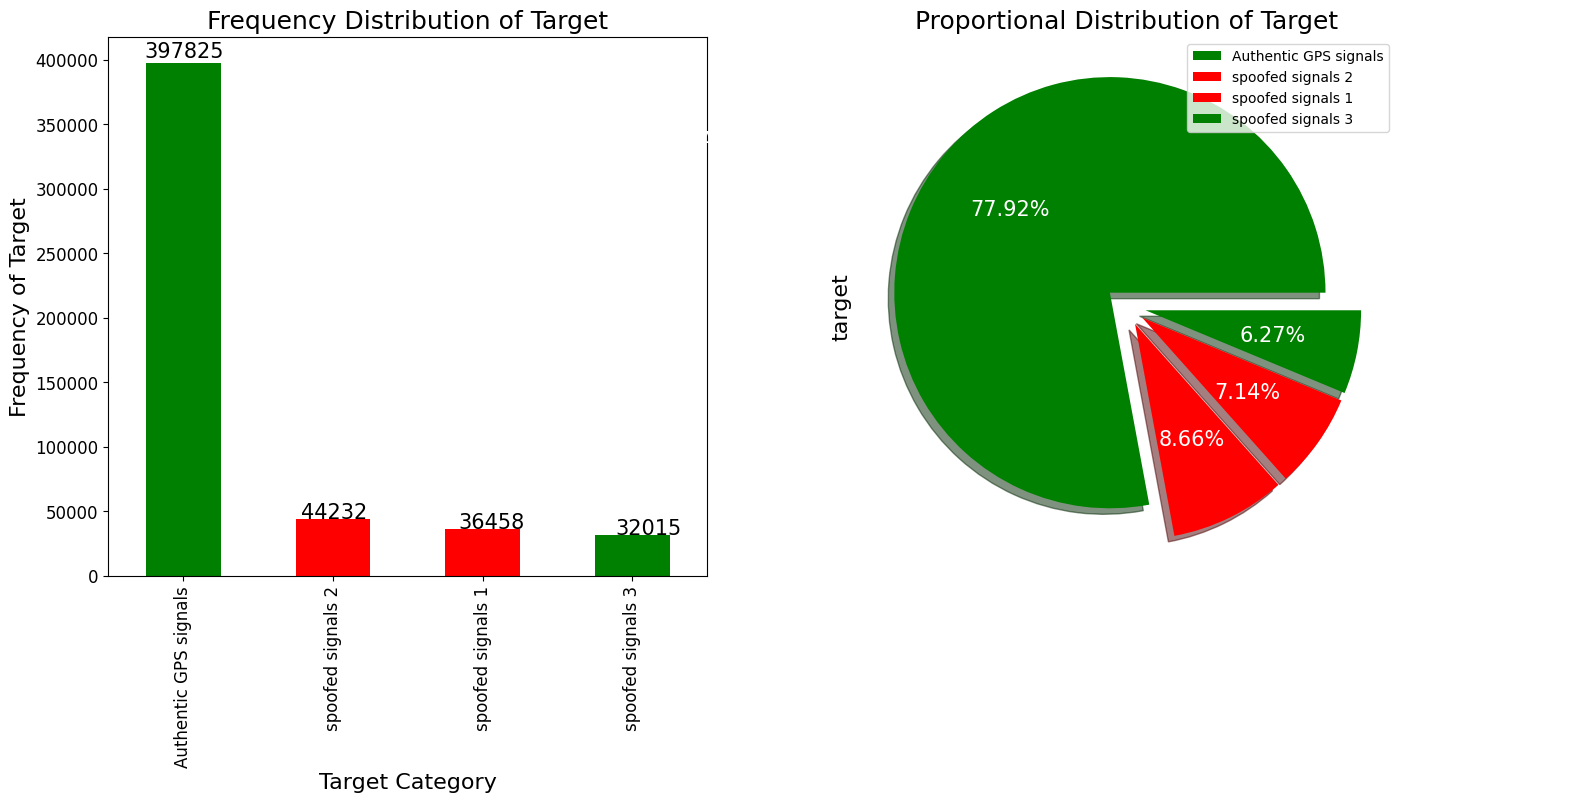

In [ ]:
target_distribution(df, 'Output')

- From above, we can see the distribution of results in which our target feature is in imbalanced form.
- Clearly, we can see that our dataset is imbalanced form. Therefore, accuracy evaluation is not good when the dataset is in an imbalanced form, accuracy is biased on the majority class.
- We will check the different performance metrics Precision, Recall, F1-score, and Auc score on testing data and see how models perform according to these performance metrics.

**This distribution provides valuable information about the prevalence of the GPS in dataset and can be used to better understand the underlying patterns and relationships in your data.**

## **GPS Features Analysis**

In [ ]:
def plot_num_var(LC_data,colname,name):
    # Visualizing our dependent variable and Skewness
    fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.set_facecolor("lightgrey")

    font_family = 'sans-serif'
    sns.boxplot(y= colname,x='Output',data=LC_data,ax=ax1)
    ax1.set_ylabel(name, fontsize=14,family = font_family)
    ax1.set_xlabel('Output', fontsize=14,family = font_family, fontweight="bold")
    ax1.set_title(name + ' by target', fontweight="bold",fontsize=15,family = font_family)
    # Set the x-axis ticks (labels) with rotation
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    sns.distplot(LC_data[colname],color='y',ax=ax2,kde=True)

    mean = np.mean(LC_data[colname].dropna().tolist())
    median = LC_data[colname].median()
    mode = LC_data[colname].mode()[0]

    label_mean= ("Mean :  {:.2f}".format(mean))
    label_median = ("Median :  {:.2f}".format(median))
    label_mode = ("Mode :  {:.2f}".format(mode))

    ax2.set_title("Distribution of " + name, fontweight="bold",fontsize=15,family = font_family)
    ax2.set_ylabel('Density', fontsize=12,family = font_family)
    ax2.set_xlabel(name, fontsize=12,family = font_family)
    ax2.axvline(mean,color="g",label=label_mean)
    ax2.axvline(median,color="b",label=label_median)
    ax2.axvline(mode,color="r",label=label_mode)
    ax2.legend()
    plt.savefig(f"{name}.png", bbox_inches='tight')
    plt.show()

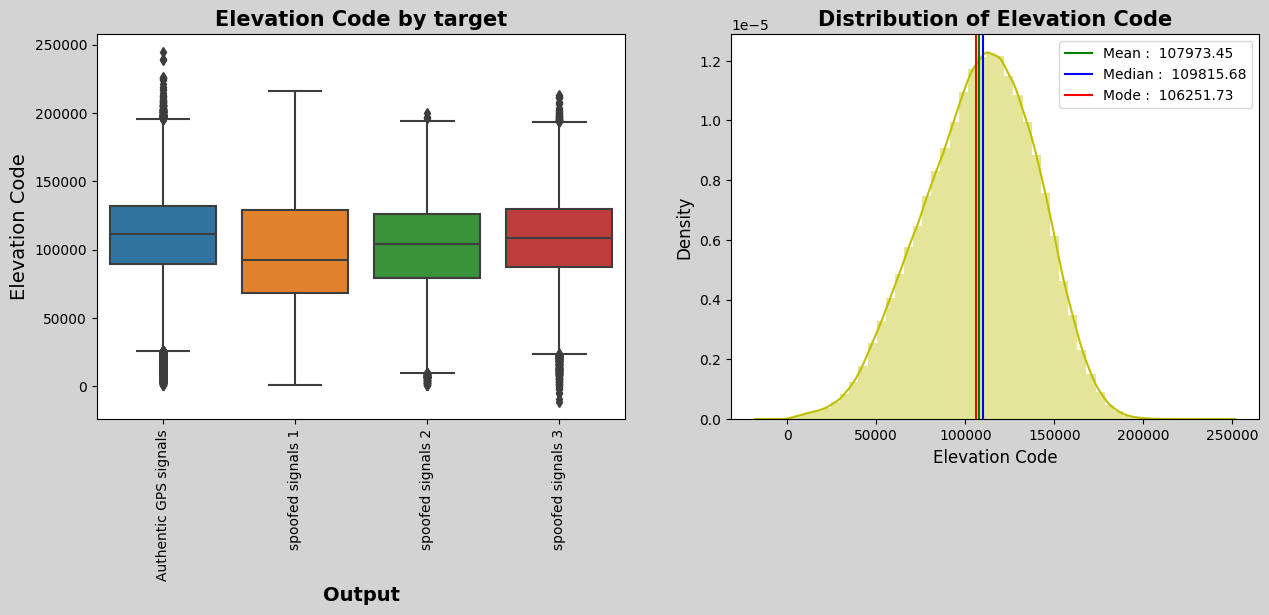

In [ ]:
df1 = df.copy()
df1['Output'] = df1['Output'].map({0:'Authentic GPS signals', 1:'spoofed signals 1', 2:'spoofed signals 2',3:'spoofed signals 3'})
plot_num_var(df1,'EC','Elevation Code')

* EC (Elevation Code): EC indicates the satellite's elevation angle, impacting signal strength and accuracy.

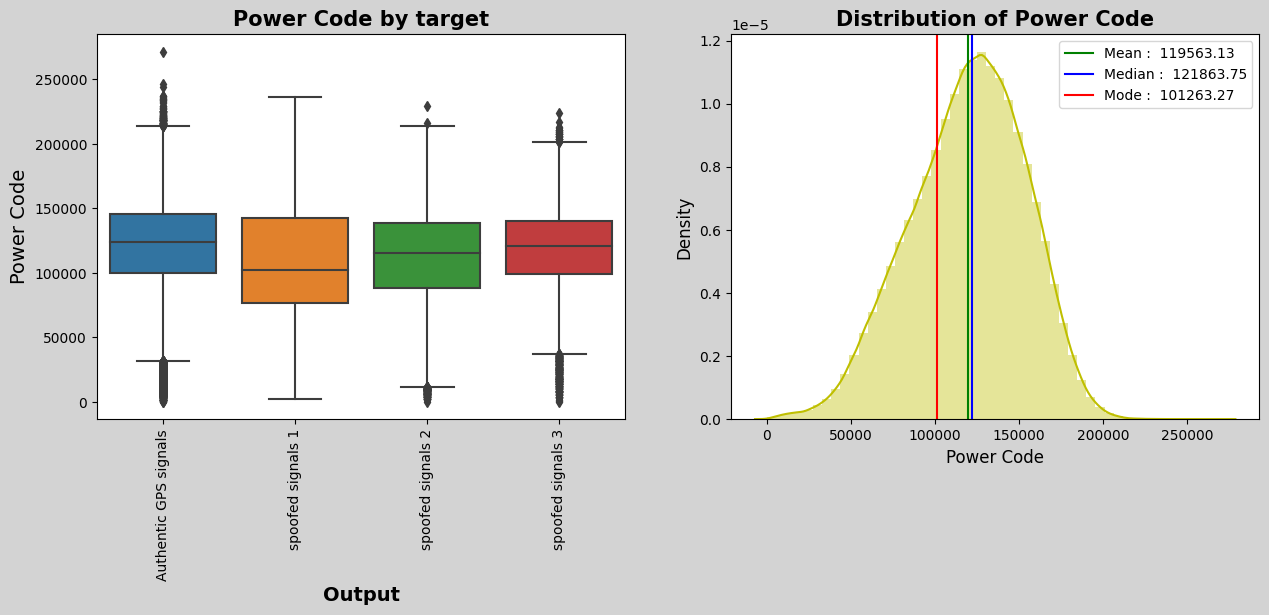

In [ ]:
plot_num_var(df1,'PC','Power Code')

* PC (Power Code): PC reflects the signal's power level, contributing to signal quality assessment.

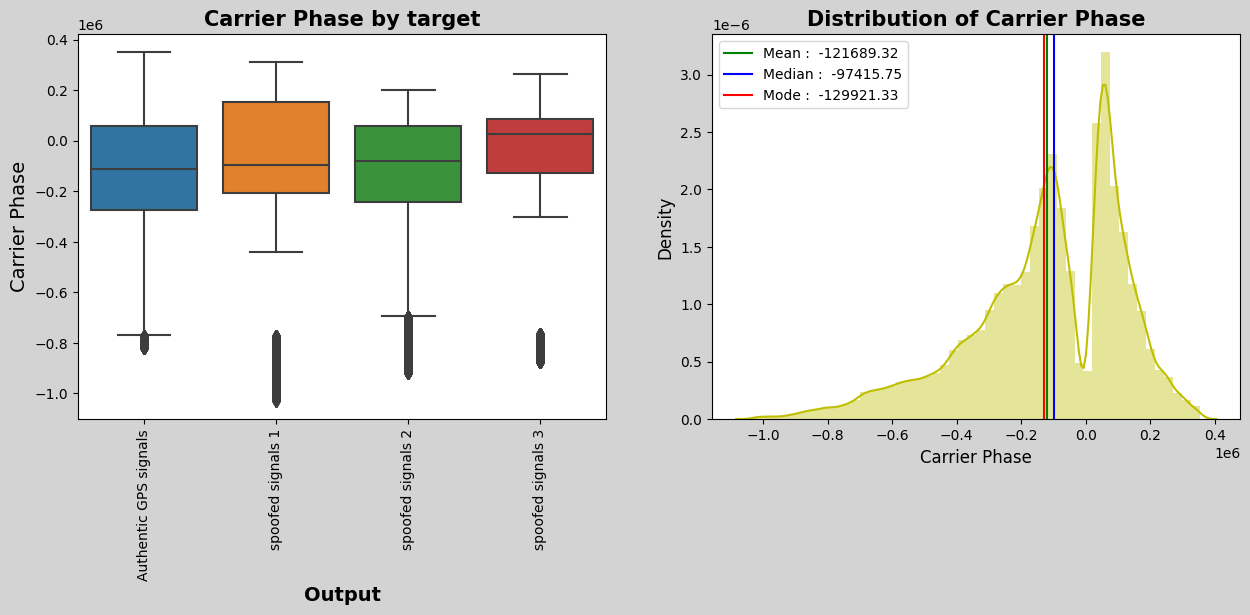

In [ ]:
plot_num_var(df1,'CP','Carrier Phase')

* CP (Carrier Phase): CP represents the phase of the GPS carrier signal, used for more accurate positioning.

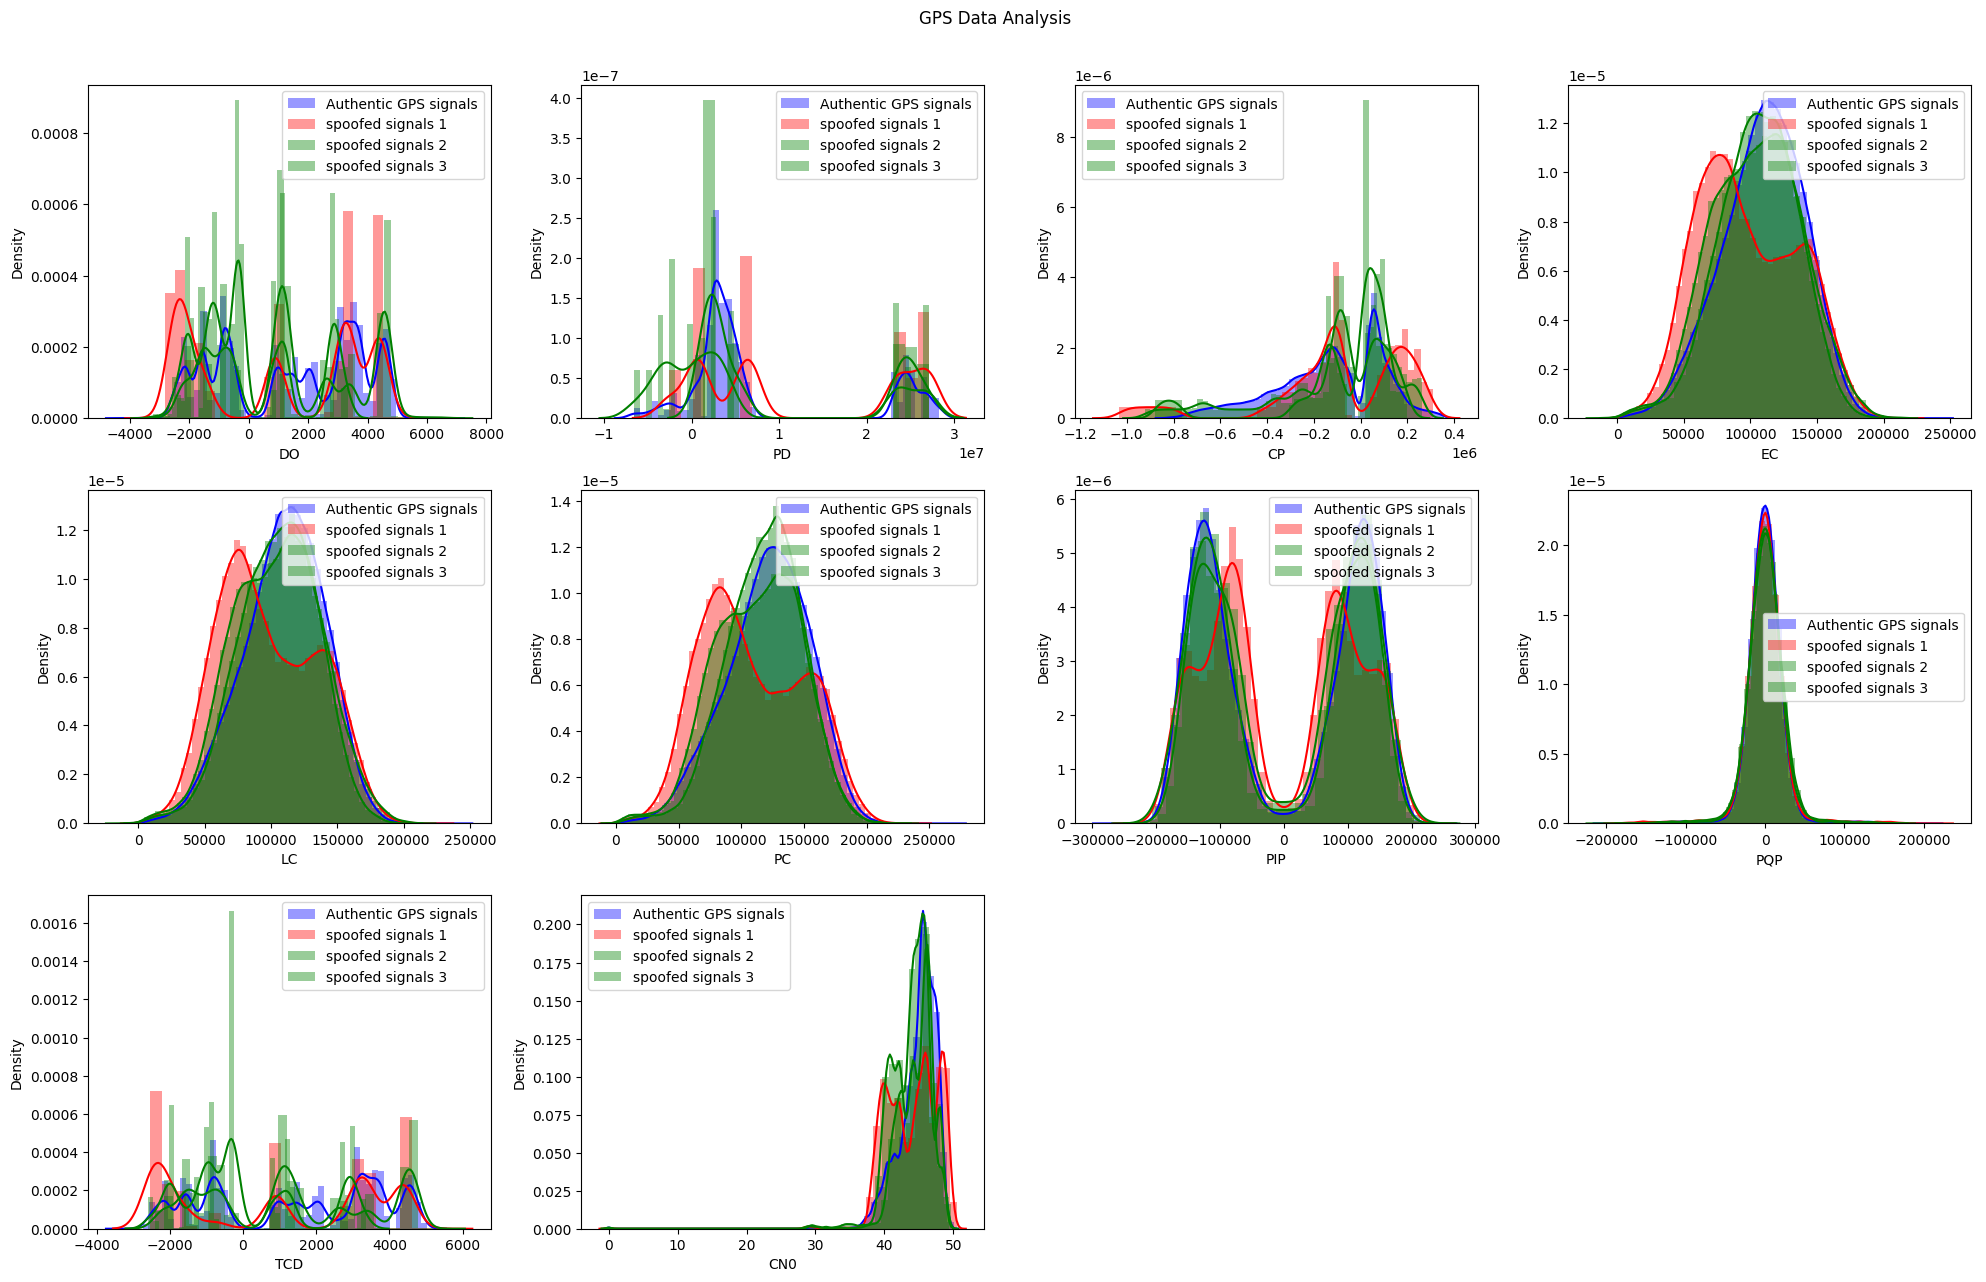

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0
num_clinical_columns= ['DO', 'PD','CP', 'EC', 'LC', 'PC', 'PIP', 'PQP',
       'TCD', 'CN0']
for i in df[num_clinical_columns].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df[i][df['Output']==0], color='b', label = 'Authentic GPS signals')
    sns.distplot(df[i][df['Output']==1], color='r', label = 'spoofed signals 1')
    sns.distplot(df[i][df['Output']==2], color='g', label = 'spoofed signals 2')
    sns.distplot(df[i][df['Output']==3], color='g', label = 'spoofed signals 3')


    plt.legend(loc='best')
fig.suptitle('GPS Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

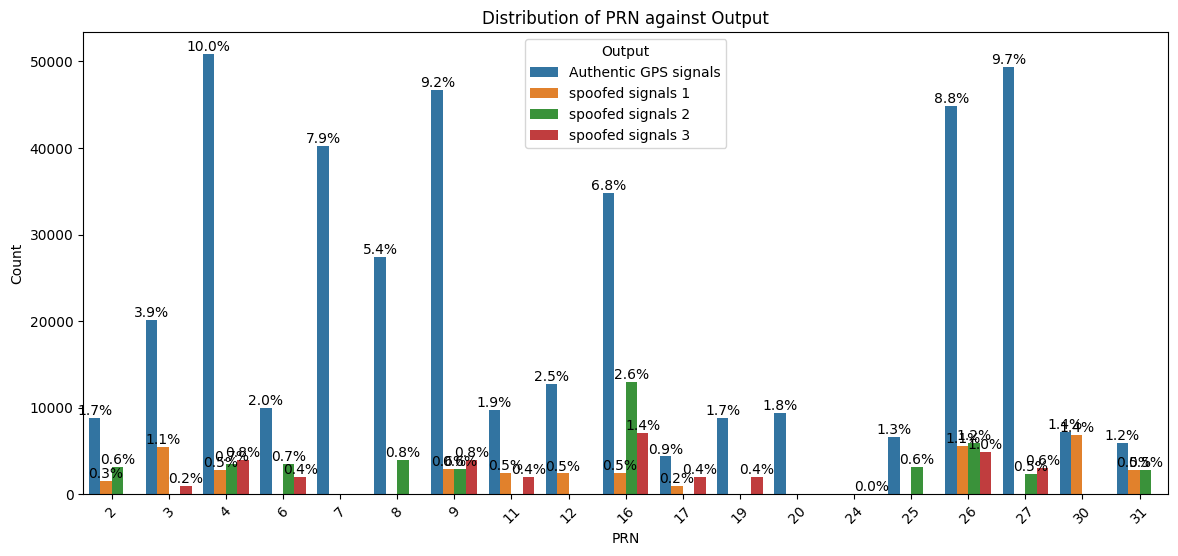

In [ ]:
# Check the distribution of PRN against Output
feature = 'PRN'
categorical_output = 'Output'

plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df1, x=feature, hue=categorical_output)
plt.title(f'Distribution of {feature} against {categorical_output}')
plt.xlabel(feature)
plt.ylabel('Count')
plt.legend(title=categorical_output)
plt.xticks(rotation=45)

# Add percentage labels to the y-axis
total_counts = len(df1)
for p in ax.patches:
    height = p.get_height()
    percentage = height / total_counts
    if percentage > 0:
        ax.annotate(f'{percentage:.1%}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)
plt.show()

* PRN (Pseudo Random Noise): PRN is a unique code assigned to each satellite that helps receivers distinguish signals from different satellites.

In [ ]:
df.head()

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.671408,-238359.543282,491568.00,491568.000795,-24660.263293,163521.78,170008.81,179294.97,178420.33,-17688.17800,1158.4806,49.412529,0
1,6,1157.827808,-238363.921192,491568.02,491568.020795,-24683.468520,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.135932,-238368.638615,491568.04,491568.040795,-24706.687357,184442.36,193125.89,208228.02,-205198.30,35391.59000,1157.6909,49.480145,0
3,6,1161.156617,-238373.391775,491568.06,491568.060795,-24729.920039,159812.45,169960.55,187550.72,187543.00,-1701.94400,1161.1343,49.433769,0
4,6,1160.690893,-238378.127066,491568.08,491568.080795,-24753.153999,183557.66,191912.58,208403.50,208330.05,-5532.89990,1161.1759,49.391670,0


##  **Check Correlation**

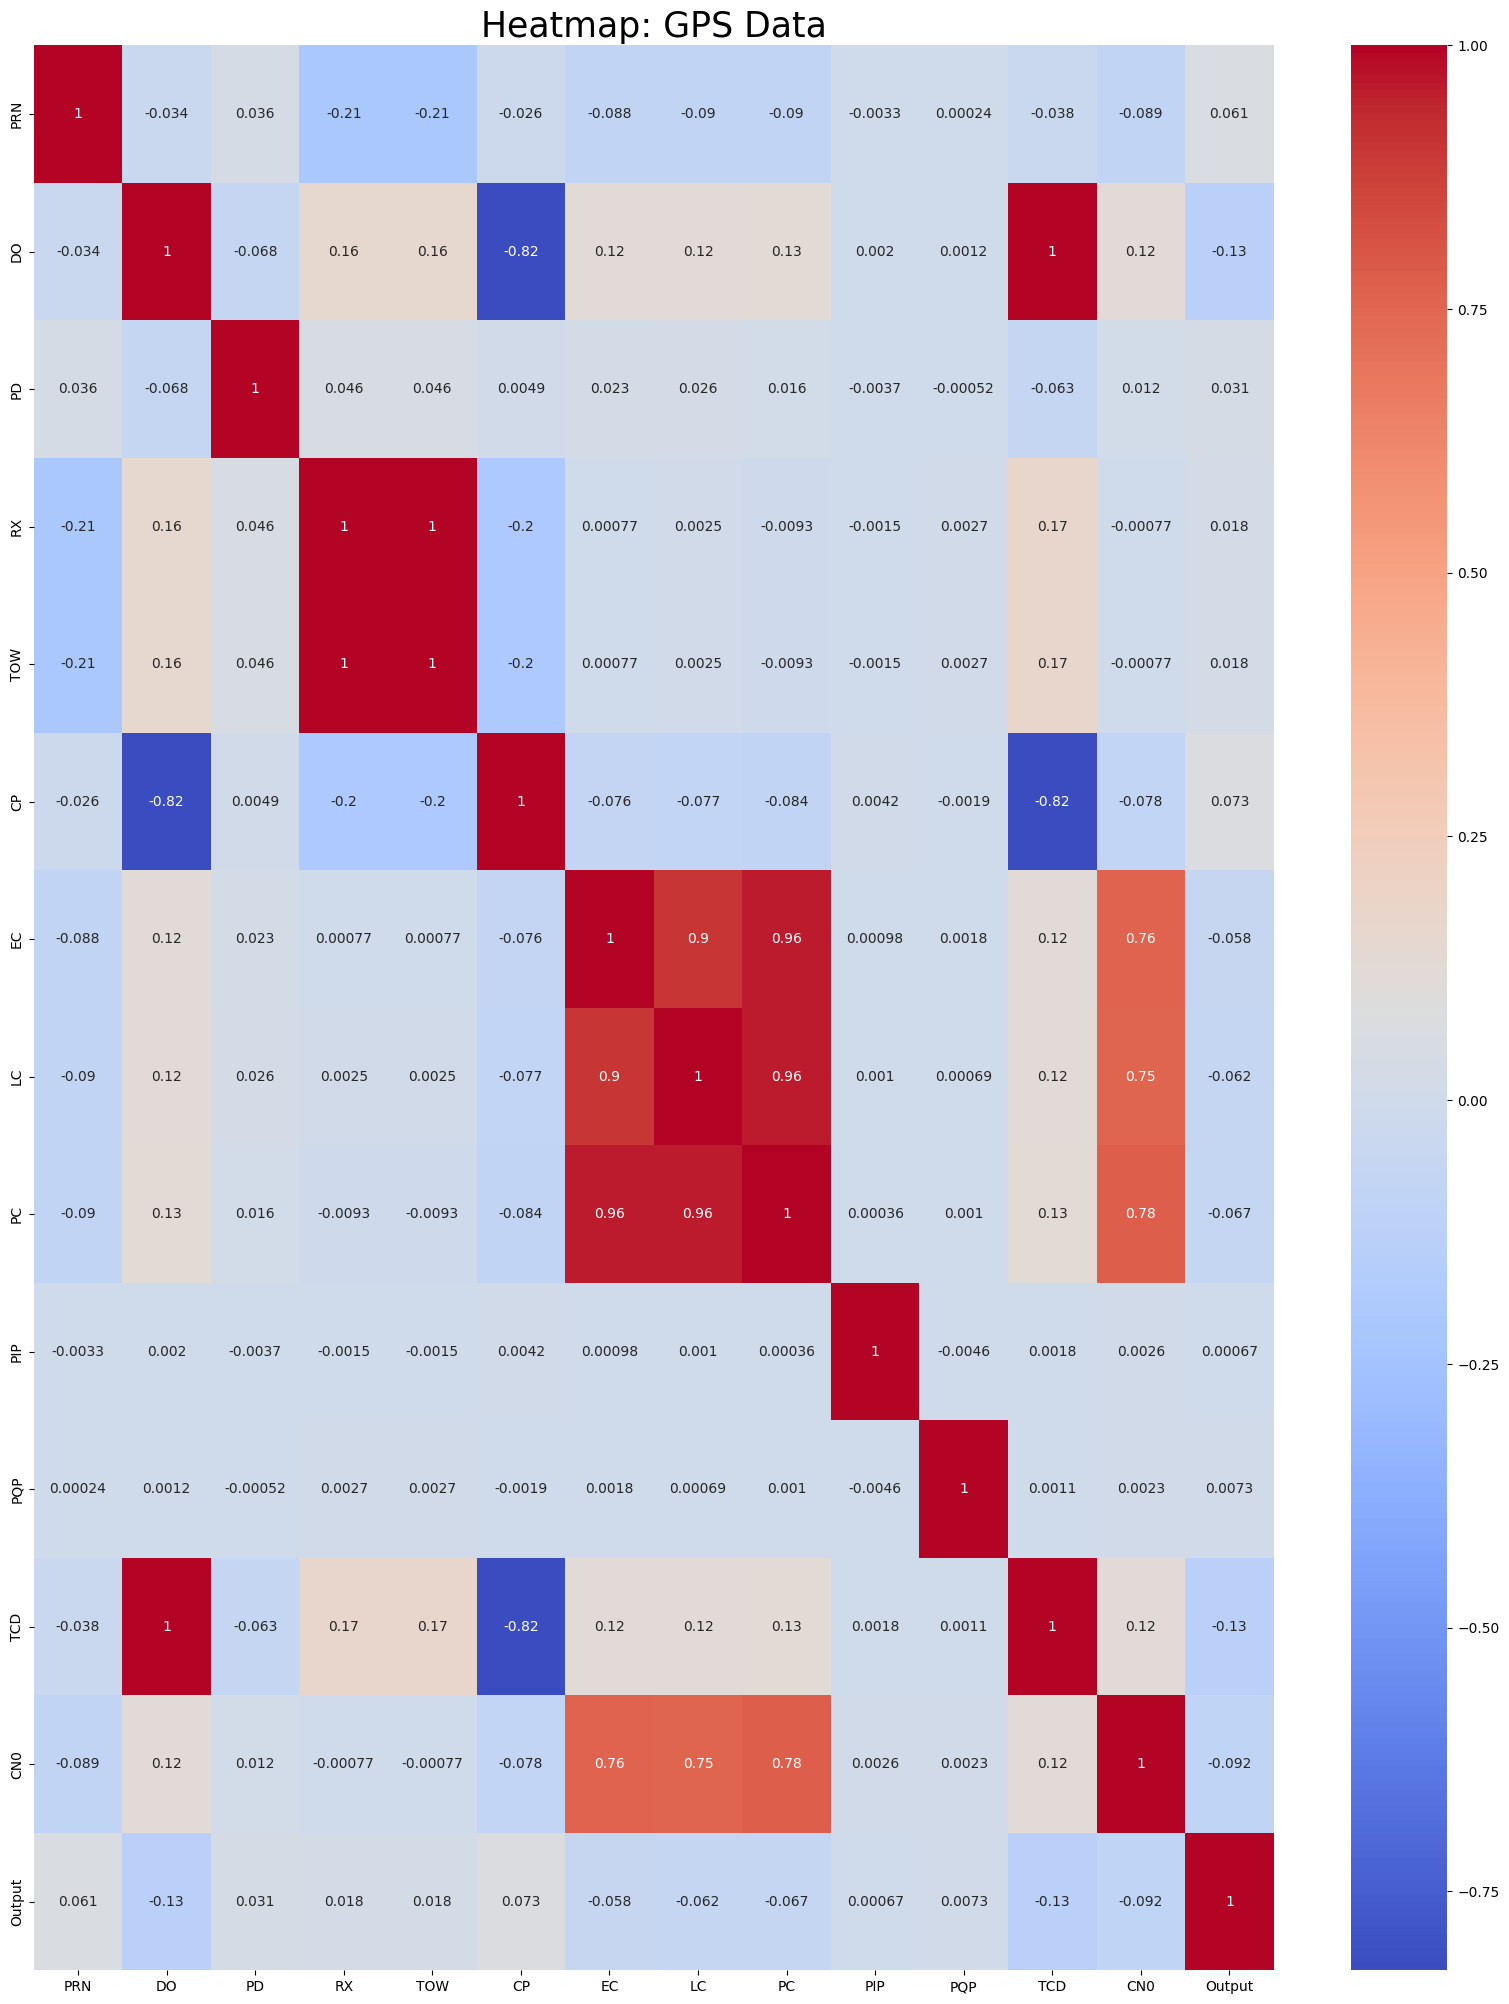

In [ ]:
# creates a heatmap of the correlation matrix of a pandas DataFrame
plt.figure(figsize=(20,25))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.title("Heatmap: GPS Data", fontsize=25)
plt.show()

In [ ]:
def check_correlation(df):
  # Calculate the correlation matrix
  correlation_matrix = df.corr()[['Output']].sort_values(by='Output', ascending=False)

  # Rename the correlation column to 'Correlation with Energy Usage'
  correlation_matrix = correlation_matrix.rename(columns={'Output': 'Correlation with Output'})

  # Display the correlation matrix as a table
  print("Correlation Matrix:")
  print(correlation_matrix)
  return correlation_matrix

In [ ]:
# Calculate the correlation matrix
correlation_matrix = check_correlation(df)

Correlation Matrix:
        Correlation with Output
Output                 1.000000
CP                     0.073355
PRN                    0.060742
PD                     0.031344
TOW                    0.017606
RX                     0.017606
PQP                    0.007277
PIP                    0.000670
EC                    -0.057889
LC                    -0.062232
PC                    -0.066992
CN0                   -0.091590
TCD                   -0.128014
DO                    -0.130943


## **ANOVA Test**

* When we have a categorical output feature and a numerical input feature, we can use the Analysis of Variance (ANOVA) test to check the association between the features. ANOVA is a statistical method used to analyze the differences among group means in a sample. It can help determine whether there are statistically significant differences in the means of the numerical input feature across different categories of the categorical output feature.

In [ ]:
from scipy.stats import f_oneway

def check_feature_association_through_ANOVA_test(df, input_feature_list, output_feature):
  association_featues = []
  for i in input_feature_list:
      # Split data based on unique values of the output feature
      output_categories = df[output_feature].unique()
      data_groups = [df[df[output_feature] == category][i] for category in output_categories]

      # Perform ANOVA test
      statistic, p_value = f_oneway(*data_groups)


      # Check if the p-value is below your significance level (e.g., 0.05) to determine significance
      if p_value < 0.05:
          association_featues.append(i)
          print(f"✅ There is a significant association between the features ({i} and {output_feature}).")
      else:
          print()
          print(f"❌ There is no significant association between the features ({i} and {output_feature}).")

      # Print the results
      print(f"ANOVA Statistic: {statistic}")
      print(f"P-value: {p_value}")
      print()

  return association_featues

In [ ]:
features = ['DO', 'PD', 'RX', 'TOW', 'CP', 'EC', 'LC', 'PC', 'PIP', 'PQP',
       'TCD', 'CN0']

In [ ]:
association_featues = check_feature_association_through_ANOVA_test(df, features, 'Output')

✅ There is a significant association between the features (DO and Output).
ANOVA Statistic: 4111.082978152244
P-value: 0.0

✅ There is a significant association between the features (PD and Output).
ANOVA Statistic: 3095.0114560494712
P-value: 0.0

✅ There is a significant association between the features (RX and Output).
ANOVA Statistic: 1553.4488735111772
P-value: 0.0

✅ There is a significant association between the features (TOW and Output).
ANOVA Statistic: 1553.4480796753444
P-value: 0.0

✅ There is a significant association between the features (CP and Output).
ANOVA Statistic: 1637.536426166284
P-value: 0.0

✅ There is a significant association between the features (EC and Output).
ANOVA Statistic: 2054.3456582308195
P-value: 0.0

✅ There is a significant association between the features (LC and Output).
ANOVA Statistic: 2091.3990256859693
P-value: 0.0

✅ There is a significant association between the features (PC and Output).
ANOVA Statistic: 2208.355991317922
P-value: 0.0

✅ 

In [ ]:
association_featues

['DO', 'PD', 'RX', 'TOW', 'CP', 'EC', 'LC', 'PC', 'PIP', 'PQP', 'TCD', 'CN0']

In [ ]:
df_copy = df[['PRN']+association_featues+['Output']]

In [ ]:
# lets extract the dependent and independent features
X = df_copy.drop('Output', axis=1)
y = df_copy['Output']

In [ ]:
import random
np.random.seed(42)
random.seed(42)

### **Split Train Test**

- The purpose of this split is to allow you to train your model on one set of data and then evaluate its performance on another set of data that it hasn't seen before.

- The most common split is a 70/30 or 80/20 split, where the larger portion is used for training the model and the smaller portion is used for evaluating its performance. The training set is used to fit the model to the data, while the testing set is used to evaluate the model's performance in making predictions on new, unseen data.

- **So, we decide to split the dataset 80% for training and 20% for testing.**

In [ ]:
def splitting_dataset(X, y, test_size=0.20):
    from sklearn.model_selection import train_test_split

    assert X.shape[0] == y.shape[0], "Number of samples in X and y should be the same."

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # Check the shape of training and testing sets
    print("Training shape:", X_train.shape)
    print("Testing shape:", X_test.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
# lets split the dataset stratified
X_train, X_test, y_train, y_test = splitting_dataset(X, y , test_size=0.2)

Training shape: (408424, 13)
Testing shape: (102106, 13)


## **Normalize the Data**
* Normalization, in the context of data analysis and machine learning, refers to the process of transforming numerical data into a standardized scale. The goal of normalization is to bring different features or variables onto a similar scale to ensure fair comparisons and improve the performance of certain algorithms.

In [ ]:

'''
Feature scaling marks the end of the data preprocessing in Machine Learning. It is a method to standardize the independent variables of a dataset within a specific range.
In other words, feature scaling limits the range of variables so that you can compare them on common grounds.

'''

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns = X_train.columns)

## **Model Building**

In [ ]:
# Import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
def results(model, y_pred, y_test,y_pred_train,y_train, classes, multi_class=False):
    if multi_class:
        accuracy = round(accuracy_score(y_pred, y_test)*100,2)
        train_accuracy = round(accuracy_score(y_pred_train, y_train)*100,2)
        precision = round(precision_score(y_pred, y_test, average='macro')*100,2)
        recall = round(recall_score(y_pred, y_test, average='macro')*100,2)
        f1_scr = round(f1_score(y_pred, y_test, average='macro')*100,2)
    else:
        accuracy = round(accuracy_score(y_pred, y_test)*100,2)
        train_accuracy = round(accuracy_score(y_pred_train, y_train)*100,2)
        precision = round(precision_score(y_pred, y_test)*100,2)
        recall = round(recall_score(y_pred, y_test)*100,2)
        f1_scr = round(f1_score(y_pred, y_test)*100,2)


    print("\nTraining Accuracy: {}%".format(train_accuracy))
    print("Testing Accuracy: {}%".format(accuracy))
    print("Precision: {}%".format(precision))
    print("Recall: {}%".format(recall))
    print("F1-Score: {}%".format(f1_scr))
    print()
    print("Classification Report:")
    print(classification_report(y_pred, y_test, target_names=classes))
    print()
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7,5))
    ConfusionMatrixDisplay.from_predictions(y_pred, y_test,
                                            ax=ax,
                                            display_labels=classes,
                                            xticks_rotation='vertical')
    plt.show()

    return {
        'Model':model.__class__.__name__,
        'Training Accuracy': train_accuracy,
        'Testing Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1_scr
    }

In [ ]:
def train_model(model,X_train,y_train,X_test,y_test, labelEncoder, multi_class=False):
    # Record the start time
    start_time = time.time()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Record the end time
    end_time = time.time()

    # Compute the training time in seconds
    training_time = end_time - start_time
    print(f"Training time: {training_time:.3f} seconds")

    # predict the model on testing data
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    # get results
    RESULTS_LR = results(model, y_pred, y_test,y_pred_train, y_train, labelEncoder, multi_class)

    # Add the training time to RESULTS_LR
    RESULTS_LR['Training time (s)'] = training_time

    return RESULTS_LR, model

In [ ]:
def get_model_results(res):
  # Convert the dictionary to a DataFrame
  return pd.DataFrame.from_dict([res]).set_index('Model')

In [ ]:
MODELS = {
    'RANDOM FOREST MODEL': RandomForestClassifier(),
    'LOGISTIC REGRESSION MODEL': LogisticRegression(),
    # 'SVM MODEL': SVC(),
    'DECISION TREE MODEL': DecisionTreeClassifier(),
    'XGBOOST MODEL': XGBClassifier()
}

####################################################################################################
				 RANDOM FOREST MODEL
####################################################################################################
Training time: 238.025 seconds

Training Accuracy: 99.25%
Testing Accuracy: 89.87%
Precision: 79.6%
Recall: 79.8%
F1-Score: 79.7%

Classification Report:
                       precision    recall  f1-score   support

Authentic GPS signals       0.95      0.95      0.95     79726
    spoofed signals 1       0.74      0.74      0.74      7271
    spoofed signals 2       0.57      0.58      0.58      8704
    spoofed signals 3       0.92      0.92      0.92      6405

             accuracy                           0.90    102106
            macro avg       0.80      0.80      0.80    102106
         weighted avg       0.90      0.90      0.90    102106


Confusion Matrix:


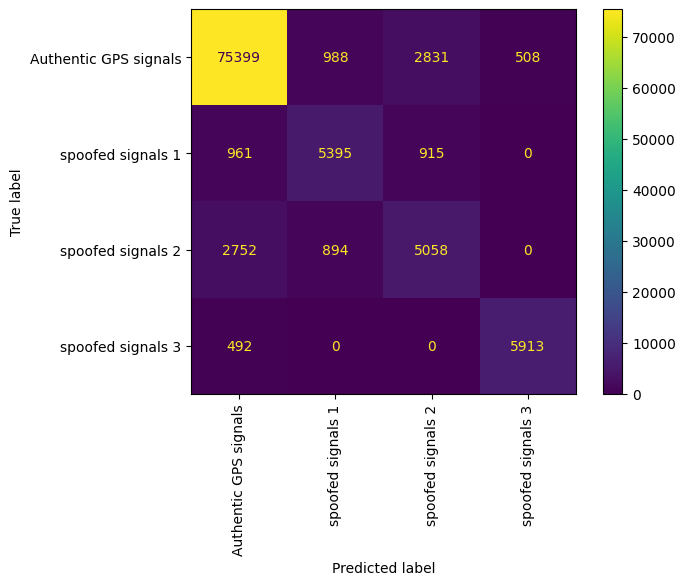

####################################################################################################
				 LOGISTIC REGRESSION MODEL
####################################################################################################
Training time: 14.967 seconds

Training Accuracy: 77.88%
Testing Accuracy: 77.92%
Precision: 25.0%
Recall: 27.21%
F1-Score: 21.93%

Classification Report:
                       precision    recall  f1-score   support

Authentic GPS signals       1.00      0.78      0.88    102047
    spoofed signals 1       0.00      0.00      0.00         0
    spoofed signals 2       0.00      0.06      0.00        51
    spoofed signals 3       0.00      0.25      0.00         8

             accuracy                           0.78    102106
            macro avg       0.25      0.27      0.22    102106
         weighted avg       1.00      0.78      0.88    102106


Confusion Matrix:


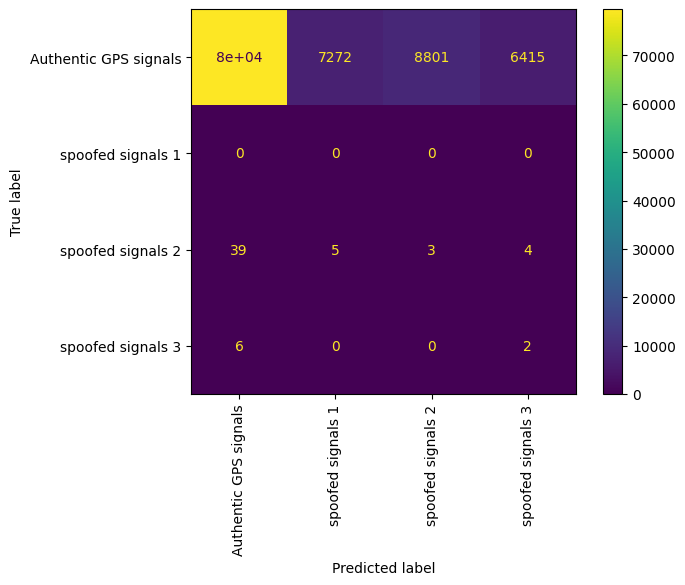

####################################################################################################
				 DECISION TREE MODEL
####################################################################################################
Training time: 19.926 seconds

Training Accuracy: 99.25%
Testing Accuracy: 91.96%
Precision: 84.04%
Recall: 84.53%
F1-Score: 84.28%

Classification Report:
                       precision    recall  f1-score   support

Authentic GPS signals       0.96      0.95      0.96     79779
    spoofed signals 1       0.81      0.82      0.81      7202
    spoofed signals 2       0.68      0.68      0.68      8788
    spoofed signals 3       0.92      0.93      0.93      6337

             accuracy                           0.92    102106
            macro avg       0.84      0.85      0.84    102106
         weighted avg       0.92      0.92      0.92    102106


Confusion Matrix:


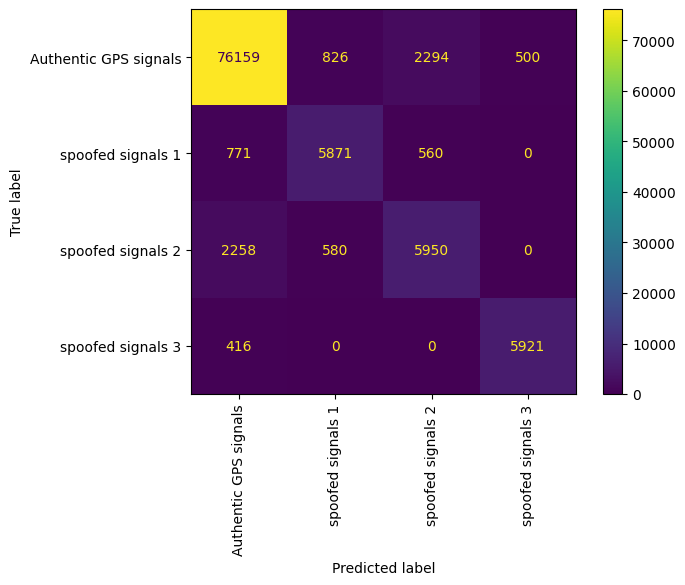

####################################################################################################
				 XGBOOST MODEL
####################################################################################################
Training time: 595.566 seconds

Training Accuracy: 95.45%
Testing Accuracy: 93.07%
Precision: 85.41%
Recall: 86.91%
F1-Score: 86.14%

Classification Report:
                       precision    recall  f1-score   support

Authentic GPS signals       0.97      0.96      0.96     80252
    spoofed signals 1       0.81      0.86      0.83      6922
    spoofed signals 2       0.70      0.72      0.71      8546
    spoofed signals 3       0.93      0.94      0.93      6386

             accuracy                           0.93    102106
            macro avg       0.85      0.87      0.86    102106
         weighted avg       0.93      0.93      0.93    102106


Confusion Matrix:


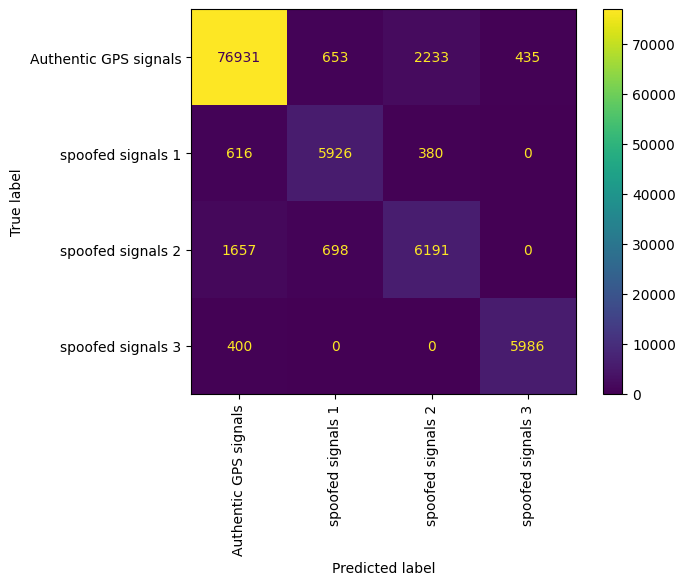

In [ ]:
classes = ['Authentic GPS signals', 'spoofed signals 1',
           'spoofed signals 2', 'spoofed signals 3']
RES = []

for model_name, model in MODELS.items():
  print("#"*100)
  print(f"\t\t\t\t {model_name}")
  print("#"*100)
  res, dt = train_model(model,X_train_std,y_train,X_test_std,y_test,  classes, multi_class=True)
  df_results_dt = get_model_results(res)
  RES.append(df_results_dt)

## **Models Evaluation**

In [ ]:
df_all_models = pd.concat(RES)
models_pd_ = df_all_models.reset_index()
models_pd_

,Model,Training Accuracy,Testing Accuracy,Precision,Recall,F1,Training time (s)
0,RandomForestClassifier,99.25,89.87,79.60,79.80,79.70,238.025219
1,LogisticRegression,77.88,77.92,25.00,27.21,21.93,14.966792
2,DecisionTreeClassifier,99.25,91.96,84.04,84.53,84.28,19.925636
3,XGBClassifier,95.45,93.07,85.41,86.91,86.14,595.565749


* From the above graph, we can see that XGBoost performing well as compared to other models.

In [ ]:
def plot_performance_metrics_graph(df):
    df.T.plot(kind='bar', figsize=(15,5))
    plt.ylabel('Scores',fontsize=18)
    plt.xlabel('Models',fontsize=18)
    plt.legend(ncol=6, bbox_to_anchor=(1,1.15))
    plt.show()

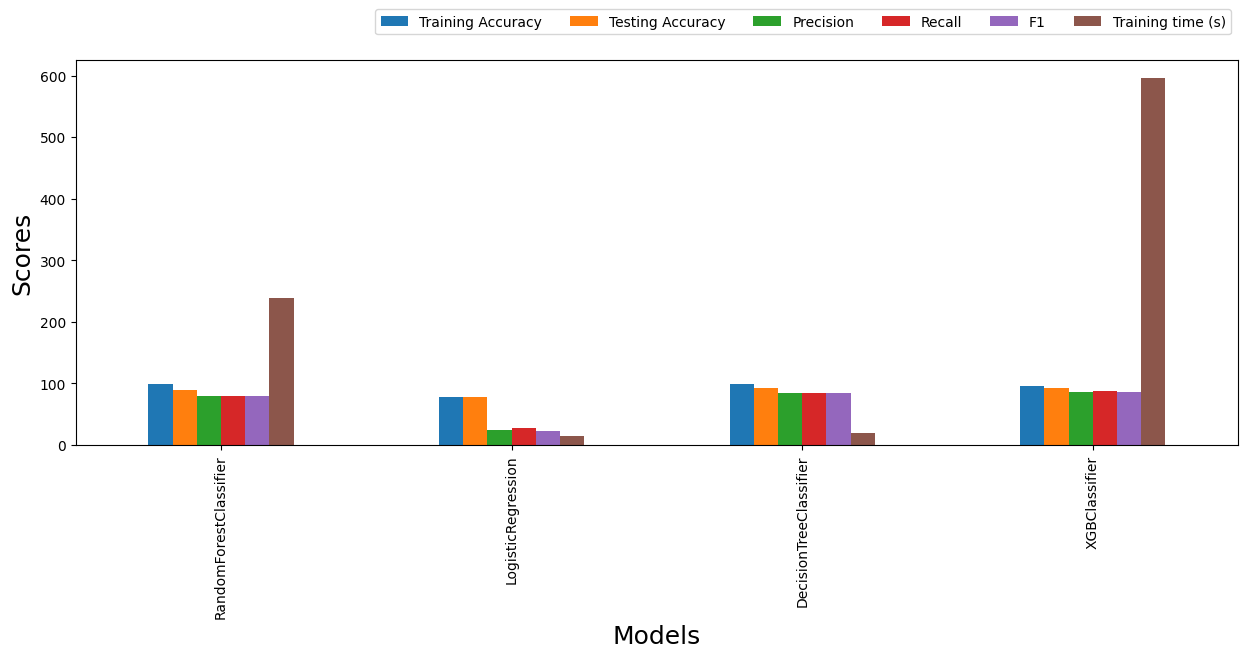

In [ ]:
plot_performance_metrics_graph(models_pd_.set_index("Model").T)

In [ ]:
def plot_accuracy(RESULTS):
    # Plot the R2 scores for testing and training data
    plt.figure(figsize=(10, 6))
    x = range(len(RESULTS.index))
    bar_width = 0.35

    plt.bar(x, RESULTS['Testing Accuracy'], width=bar_width, label='Testing Score')
    plt.bar([i + bar_width for i in x], RESULTS['Training Accuracy'], width=bar_width, label='Training Score')

    plt.xlabel('Model')
    plt.ylabel('R2 Score')
    plt.title('R2 Score Comparison for Testing and Training Data')
    plt.xticks([i + bar_width/2 for i in x], RESULTS.index, rotation=45, ha='right')
    plt.legend()
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    for i in x:
        plt.text(i - 0.06, RESULTS['Testing Accuracy'][i] + 0.005, f"{RESULTS['Testing Accuracy'][i]:.2f}", color='black')
        plt.text(i + bar_width - 0.06, RESULTS['Training Accuracy'][i] + 0.005, f"{RESULTS['Training Accuracy'][i]:.2f}", color='black')

    plt.tight_layout()
    plt.show()

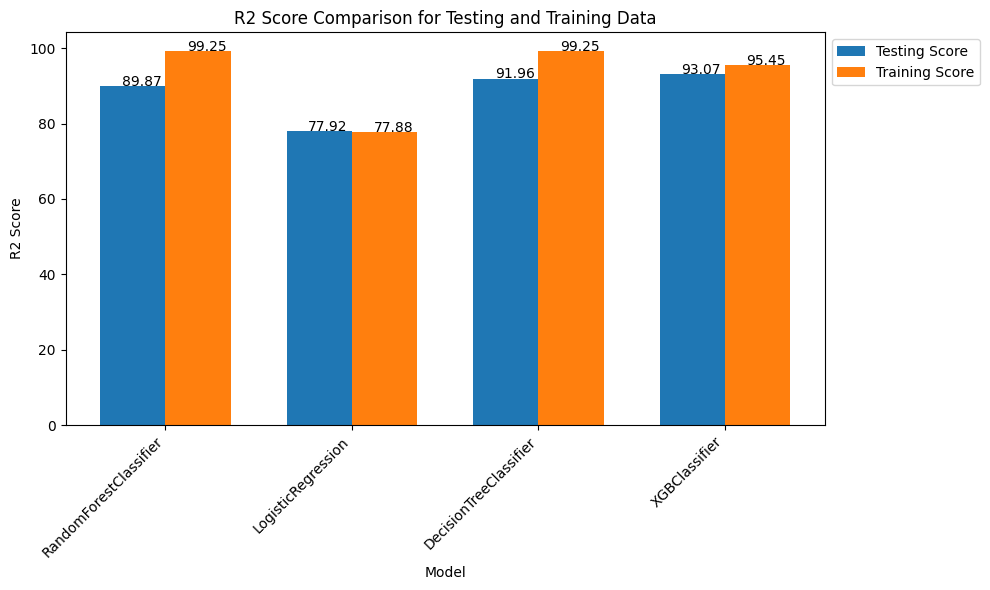

In [ ]:
plot_accuracy(models_pd_.set_index("Model"))